In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [2]:
X_class1 = np.load('../data/real_movement_class_1.npy').T
X_class2 = np.load('../data/real_movement_class_2.npy').T

In [3]:
X = np.concatenate([X_class1, X_class2], axis=0)
y = np.concatenate([np.zeros(X_class1.shape[0]), np.ones(X_class2.shape[0])])  # 0 = class1, 1 = class2

In [4]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3)

In [6]:
clf_l2 = LinearSVC(penalty='l2', C=1.0, dual=True)
clf_l1 = LinearSVC(penalty='l1', C=1.0, dual=False)  # dual=False required for L1

In [7]:
clf_l2.fit(X_train, y_train)
clf_l1.fit(X_train, y_train)

LinearSVC(dual=False, penalty='l1')

In [8]:
y_pred_l2 = clf_l2.predict(X_test)
y_pred_l1 = clf_l1.predict(X_test)

acc_l2 = accuracy_score(y_test, y_pred_l2)
acc_l1 = accuracy_score(y_test, y_pred_l1)

In [9]:
print(f"L2 Accuracy: {acc_l2:.2f}")
print(f"L1 Accuracy: {acc_l1:.2f}")

L2 Accuracy: 0.97
L1 Accuracy: 0.96


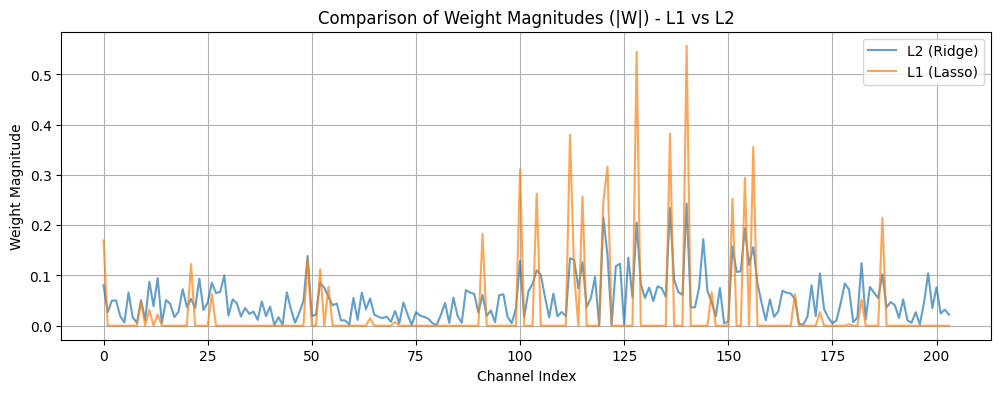

In [10]:
W_l2 = clf_l2.coef_.flatten()
W_l1 = clf_l1.coef_.flatten()

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(np.abs(W_l2), label='L2 (Ridge)', alpha=0.7)
ax.plot(np.abs(W_l1), label='L1 (Lasso)', alpha=0.7)
ax.set_title("Comparison of Weight Magnitudes (|W|) - L1 vs L2")
ax.set_xlabel("Channel Index")
ax.set_ylabel("Weight Magnitude")
ax.legend()
ax.grid(True)

## Cross validation

In [11]:
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm
import pandas as pd
import seaborn as sns

In [12]:
skf = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)
accs_l1 = []
accs_l2 = []
fold_ids = []

In [13]:
for i, (train_idx, test_idx) in enumerate(tqdm(skf.split(X, y), total=6)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # L2 (Ridge)
    clf_l2 = LinearSVC(penalty='l2', C=1.0, dual=True, max_iter=10000)
    clf_l2.fit(X_train, y_train)
    acc_l2 = accuracy_score(y_test, clf_l2.predict(X_test))
    accs_l2.append(acc_l2)

    # L1 (Lasso)
    clf_l1 = LinearSVC(penalty='l1', C=1.0, dual=False, max_iter=10000)
    clf_l1.fit(X_train, y_train)
    acc_l1 = accuracy_score(y_test, clf_l1.predict(X_test))
    accs_l1.append(acc_l1)

    fold_ids.append(f"Fold {i+1}")

100%|██████████| 6/6 [00:00<00:00, 44.25it/s]


In [14]:
# Create DataFrame for visualization
df_results = pd.DataFrame({
    'Fold': fold_ids * 2,
    'Accuracy': accs_l2 + accs_l1,
    'Regularization': ['L2 (Ridge)'] * 6 + ['L1 (Lasso)'] * 6
})

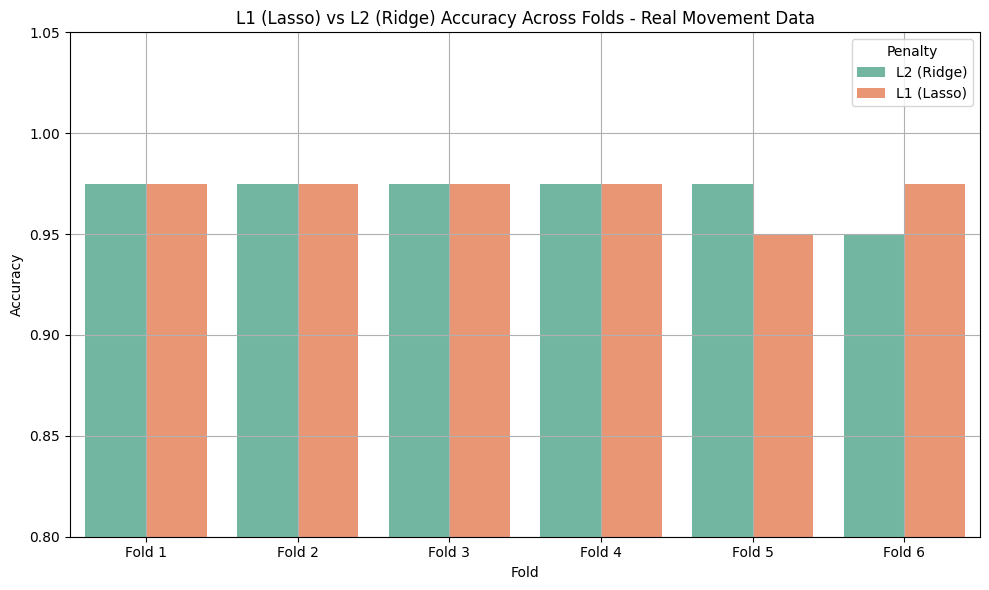

In [15]:
ig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=df_results, x='Fold', y='Accuracy', hue='Regularization', palette='Set2', ax=ax)
ax.set_title("L1 (Lasso) vs L2 (Ridge) Accuracy Across Folds - Real Movement Data")
ax.set_ylim(0.8, 1.05)
ax.grid(True)
ax.legend(title="Penalty")
plt.tight_layout()
plt.savefig('../figures/l1_vs_l2_accuracy_real_movement.png', dpi=300)
plt.show()

## Cross validation and multiple datasets Overt and Imagined

/var/folders/r5/m5977dy13hd_9klxgsmylm740000gn/T/ipykernel_99961/839179088.py:62: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_summary, x='Train', y='Accuracy', hue='Penalty', ci=None, ax=ax, palette='Set2', dodge=True)


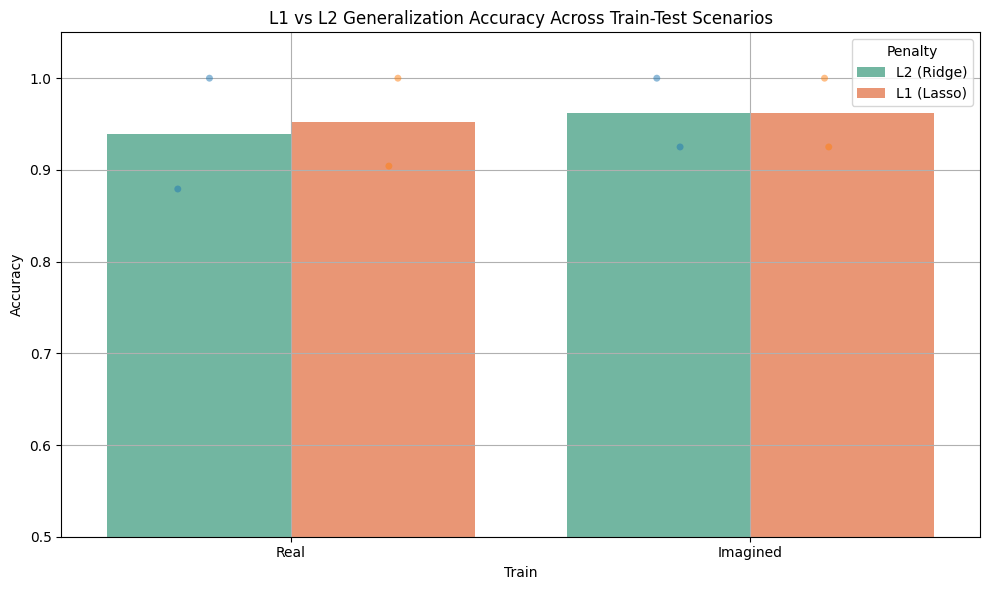

In [16]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

# Load and preprocess data
X_real_1 = np.load('../data/real_movement_class_1.npy').T
X_real_2 = np.load('../data/real_movement_class_2.npy').T
X_imag_1 = np.load('../data/imagined_movement_class_1.npy').T
X_imag_2 = np.load('../data/imagined_movement_class_2.npy').T

# Form datasets
X_real = np.concatenate((X_real_1, X_real_2), axis=0)
y_real = np.concatenate((np.zeros(X_real_1.shape[0]), np.ones(X_real_2.shape[0])))

X_imag = np.concatenate((X_imag_1, X_imag_2), axis=0)
y_imag = np.concatenate((np.zeros(X_imag_1.shape[0]), np.ones(X_imag_2.shape[0])))

# Standardize
scaler = StandardScaler()
X_real = scaler.fit_transform(X_real)
X_imag = scaler.fit_transform(X_imag)

def evaluate_train_test(X_train, y_train, X_test, y_test, train_label, test_label):
    results = []

    for penalty, dual in [('l2', True), ('l1', False)]:
        model = LinearSVC(penalty=penalty, C=1.0, dual=dual, max_iter=10000)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        results.append({
            'Train': train_label,
            'Test': test_label,
            'Penalty': 'L2 (Ridge)' if penalty == 'l2' else 'L1 (Lasso)',
            'Accuracy': acc
        })

    return results

# Define scenarios
scenarios = [
    ('Real', 'Real', X_real, y_real, X_real, y_real),
    ('Imagined', 'Imagined', X_imag, y_imag, X_imag, y_imag),
    ('Real', 'Imagined', X_real, y_real, X_imag, y_imag),
    ('Imagined', 'Real', X_imag, y_imag, X_real, y_real),
]

# Run evaluations
all_results = []
for train_label, test_label, X_tr, y_tr, X_te, y_te in scenarios:
    all_results.extend(evaluate_train_test(X_tr, y_tr, X_te, y_te, train_label, test_label))

df_summary = pd.DataFrame(all_results)

# Visualization
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=df_summary, x='Train', y='Accuracy', hue='Penalty', ci=None, ax=ax, palette='Set2', dodge=True)
sns.stripplot(data=df_summary, x='Train', y='Accuracy', hue='Penalty', dodge=True, marker='o', alpha=0.5, ax=ax, legend=False)
ax.set_title("L1 vs L2 Generalization Accuracy Across Train-Test Scenarios")
ax.set_ylim(0.5, 1.05)
ax.grid(True)
plt.tight_layout()
plt.savefig('../figures/l1_vs_l2_generalization_accuracy.png', dpi=300)
plt.show()